In [2]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
import re
from typing import Optional
from nerfstudio.cameras.rays import RaySamples, Frustums
from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils import colormaps, misc

from reni.utils.utils import find_nerfstudio_project_root, rot_z, rot_y
from reni.utils.colourspace import linear_to_sRGB

from reni.illumination_fields.reni_illumination_field import RENIFieldConfig
from reni.illumination_fields.sh_illumination_field import SphericalHarmonicIlluminationFieldConfig
from reni.illumination_fields.sg_illumination_field import SphericalGaussianFieldConfig
from reni.configs.reni_inverse_config import RENIInverse
from reni.pipelines.reni_inverse_pipeline import RENIInversePipeline
from reni.data.datamanagers.reni_inverse_datamanager import RENIInverseDataManager

In [3]:
# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

def load_model(load_dir: Path, load_step: Optional[int] = None):
    ckpt_dir = load_dir / 'nerfstudio_models'
    def clean_and_load_yaml(yaml_content):
        # Remove !!python related tags
        cleaned_content = re.sub(r'!!python[^\s]*', '', yaml_content)
        
        # Load the cleaned content
        return yaml.safe_load(cleaned_content)

    if load_step is None:
        load_step = sorted(int(x[x.find("-") + 1 : x.find(".")]) for x in os.listdir(ckpt_dir))[-1]
    
    ckpt = torch.load(ckpt_dir / f'step-{load_step:09d}.ckpt', map_location=device)
    reni_model_dict = {}
    for key in ckpt['pipeline'].keys():
        if key.startswith('_model.'):
            reni_model_dict[key[7:]] = ckpt['pipeline'][key]
    
    config_path = load_dir / 'config.yml'
    with open(config_path, 'r') as f:
        content = f.read()
        config = clean_and_load_yaml(content)

    model_config = RENIInverse.config
    model_config.pipeline.datamanager.dataparser.shininess = config['pipeline']['datamanager']['dataparser']['shininess']
    model_config.pipeline.datamanager.dataparser.subset_index = config['pipeline']['datamanager']['dataparser']['subset_index']
    model_config.pipeline.datamanager.dataparser.envmap_remove_indicies = config['pipeline']['datamanager']['dataparser']['envmap_remove_indicies']
    model_config.pipeline.model.illumination_field_ckpt_path = Path(os.path.join(*config['pipeline']['model']['illumination_field_ckpt_path']))
    model_config.pipeline.model.illumination_field = config['pipeline']['model']['illumination_field']
    if 'latent_dim' in config['pipeline']['model']['illumination_field'].keys():
        model_config.pipeline.model.illumination_field = RENIFieldConfig(
            conditioning=config['pipeline']['model']['illumination_field']['conditioning'],
            invariant_function=config['pipeline']['model']['illumination_field']['invariant_function'],
            equivariance=config['pipeline']['model']['illumination_field']['equivariance'],
            axis_of_invariance=config['pipeline']['model']['illumination_field']['axis_of_invariance'],
            positional_encoding=config['pipeline']['model']['illumination_field']['positional_encoding'],
            encoded_input=config['pipeline']['model']['illumination_field']['encoded_input'],
            latent_dim=config['pipeline']['model']['illumination_field']['latent_dim'],
            hidden_features=config['pipeline']['model']['illumination_field']['hidden_features'],
            hidden_layers=config['pipeline']['model']['illumination_field']['hidden_layers'],
            mapping_layers=config['pipeline']['model']['illumination_field']['mapping_layers'],
            mapping_features=config['pipeline']['model']['illumination_field']['mapping_features'],
            num_attention_heads=config['pipeline']['model']['illumination_field']['num_attention_heads'],
            num_attention_layers=config['pipeline']['model']['illumination_field']['num_attention_layers'],
            output_activation=config['pipeline']['model']['illumination_field']['output_activation'],
            last_layer_linear=config['pipeline']['model']['illumination_field']['last_layer_linear'],
            trainable_scale=config['pipeline']['model']['illumination_field']['trainable_scale'],
            old_implementation=config['pipeline']['model']['illumination_field']['old_implementation'],
        )
    elif 'spherical_harmonic_order' in config['pipeline']['model']['illumination_field'].keys():
        model_config.pipeline.model.illumination_field = SphericalHarmonicIlluminationFieldConfig(
            spherical_harmonic_order=config['pipeline']['model']['illumination_field']['spherical_harmonic_order']
        )
        model_config.pipeline.model.illumination_field.spherical_harmonic_order = config['pipeline']['model']['illumination_field']['spherical_harmonic_order']
    elif 'row_col_gaussian_dims' in config['pipeline']['model']['illumination_field'].keys():
        model_config.pipeline.model.illumination_field = SphericalGaussianFieldConfig(
            row_col_gaussian_dims=config['pipeline']['model']['illumination_field']['row_col_gaussian_dims']
        )

    pipeline: RENIInversePipeline = model_config.pipeline.setup(
      device=device,
      test_mode=test_mode,
      world_size=world_size,
      local_rank=local_rank,
      grad_scaler=None,
    )

    datamanager = pipeline.datamanager

    model = pipeline.model

    model.to(device)
    model.load_state_dict(reni_model_dict)
    model.eval()

    return pipeline, datamanager, model

def generate_images_from_models(output_config, model_paths):
    all_model_outputs = {}
    
    for model_path in model_paths:
        model_name = model_path.split("/")[-1]
        pipeline, datamanager, model = load_model(Path(model_path))

        render_metadata = datamanager.train_dataset.metadata['render_metadata']

        # Initialize a dictionary to hold the indices for each output_config entry
        indices_dict = {config_key: [] for config_key in output_config.keys()}

        # Iterate over each entry in output_config to get the object and env_idx
        for config_key, config_value in output_config.items():
            object_to_match = config_value['object']
            env_idx_to_match = config_value['env_idx']

            # Now iterate over render_metadata and check if the object (by checking normal_map_path)
            # and env_idx match the current output_config entry
            for index, metadata in enumerate(render_metadata):
                if (metadata['normal_map_path'].name.startswith(object_to_match) and
                    metadata['environment_map_idx'] == env_idx_to_match):
                    # If they match, append the index to the corresponding list in indices_dict
                    indices_dict[config_key].append(index)

            # Sort the indices within each list by the specular_term of their corresponding metadata
            # This assumes that the specular_term is the sorting key of interest
            indices_dict[config_key].sort(key=lambda idx: render_metadata[idx]['specular_term'])

        # indices_dict now contains a list of indices for each entry in output_config
        # {0: [0, 1, 2, 3, 4, 5],
        #  1: [132, 133, 134, 135, 136, 137],
        #  2: [12, 13, 14, 15, 16, 17],
        #  3: [144, 145, 146, 147, 148, 149]}
                
        model_outputs = {}
        
        for i, list_indices in enumerate(indices_dict.values()):
            for specular, idx in enumerate(list_indices):
                specular = 0.2 * specular
                # Your code to produce an image would go here.
                model.eval()
                ray_bundle, batch = datamanager.eval_image_at_idx(idx)

                outputs = pipeline.model.get_outputs_for_camera_ray_bundle(ray_bundle, batch)
                metrics_dict, images_dict = pipeline.model.get_image_metrics_and_images(outputs, batch)

                # image_dict['img] = combined_rgb = torch.cat([gt_rgb, predicted_rgb], dim=1)
                # image_dict['reni_envmap'] = combined_reni_envmap = torch.cat([gt_envmap, ldr_envmap, hdr_mean_log_heatmap], dim=1)
                # we want to split these into the individual components

                combined_rgb = images_dict['img']
                combined_reni_envmap = images_dict['reni_envmap']

                H, W, C = combined_rgb.shape

                gt_rgb = combined_rgb[:, :W//2, :]
                predicted_rgb = combined_rgb[:, W//2:, :]

                H, W, C = combined_reni_envmap.shape
                gt_envmap = combined_reni_envmap[:, :W//3, :]
                pred_envmap = combined_reni_envmap[:, W//3:2*W//3, :]

                # put them all into the model outputs dict

                mask = batch['mask'] # (H, W, 1)

                # use mask to set background to white
                gt_rgb[~mask.repeat(1, 1, 3)] = 1.0
                predicted_rgb[~mask.repeat(1, 1, 3)] = 1.0

                model_outputs[f'{i}_{specular:1f}'] = {
                    'gt_rgb': gt_rgb,
                    'predicted_rgb': predicted_rgb,
                    'gt_envmap': gt_envmap,
                    'pred_envmap': pred_envmap
                }
      
        all_model_outputs[model_name] = model_outputs
      
    return all_model_outputs

In [4]:
%%capture

output_config = {
  0: {
    'object': 'bunny',
    'env_idx': 5,
  },
  1: {
    'object': 'teapot',
    'env_idx': 1,
  },
  2: {
    'object': 'bunny',
    'env_idx': 2,
  },
  3: {
    'object': 'teapot',
    'env_idx': 3,
  },
}

model_paths = [
    '/workspace/outputs/reni/inverse_task/spherical_harmonics/9th_order',
    '/workspace/outputs/reni/inverse_task/reni_plus_plus/latent_dim_100',
]

output_images = generate_images_from_models(output_config, model_paths)


In [11]:
pipeline, datamanager, model = load_model(Path('/workspace/outputs/reni/inverse_task/reni_plus_plus/latent_dim_100'))

render_metadata = datamanager.train_dataset.metadata['render_metadata']

output_config = {
  0: {
    'object': 'bunny',
    'env_idx': 5,
  },
  1: {
    'object': 'teapot',
    'env_idx': 1,
  },
  2: {
    'object': 'bunny',
    'env_idx': 2,
  },
  3: {
    'object': 'teapot',
    'env_idx': 3,
  },
}

# Initialize a dictionary to hold the indices for each output_config entry
indices_dict = {config_key: [] for config_key in output_config.keys()}

# Iterate over each entry in output_config to get the object and env_idx
for config_key, config_value in output_config.items():
    object_to_match = config_value['object']
    env_idx_to_match = config_value['env_idx']

    # Now iterate over render_metadata and check if the object (by checking normal_map_path)
    # and env_idx match the current output_config entry
    for index, metadata in enumerate(render_metadata):
        if (metadata['normal_map_path'].name.startswith(object_to_match) and
            metadata['environment_map_idx'] == env_idx_to_match):
            # If they match, append the index to the corresponding list in indices_dict
            indices_dict[config_key].append(index)

    # Sort the indices within each list by the specular_term of their corresponding metadata
    # This assumes that the specular_term is the sorting key of interest
    indices_dict[config_key].sort(key=lambda idx: render_metadata[idx]['specular_term'])

Setting up training dataset...

Caching 1 out of 252 images, resampling every 200 iters.

Setting up evaluation dataset...

Caching all 252 images.

Output()

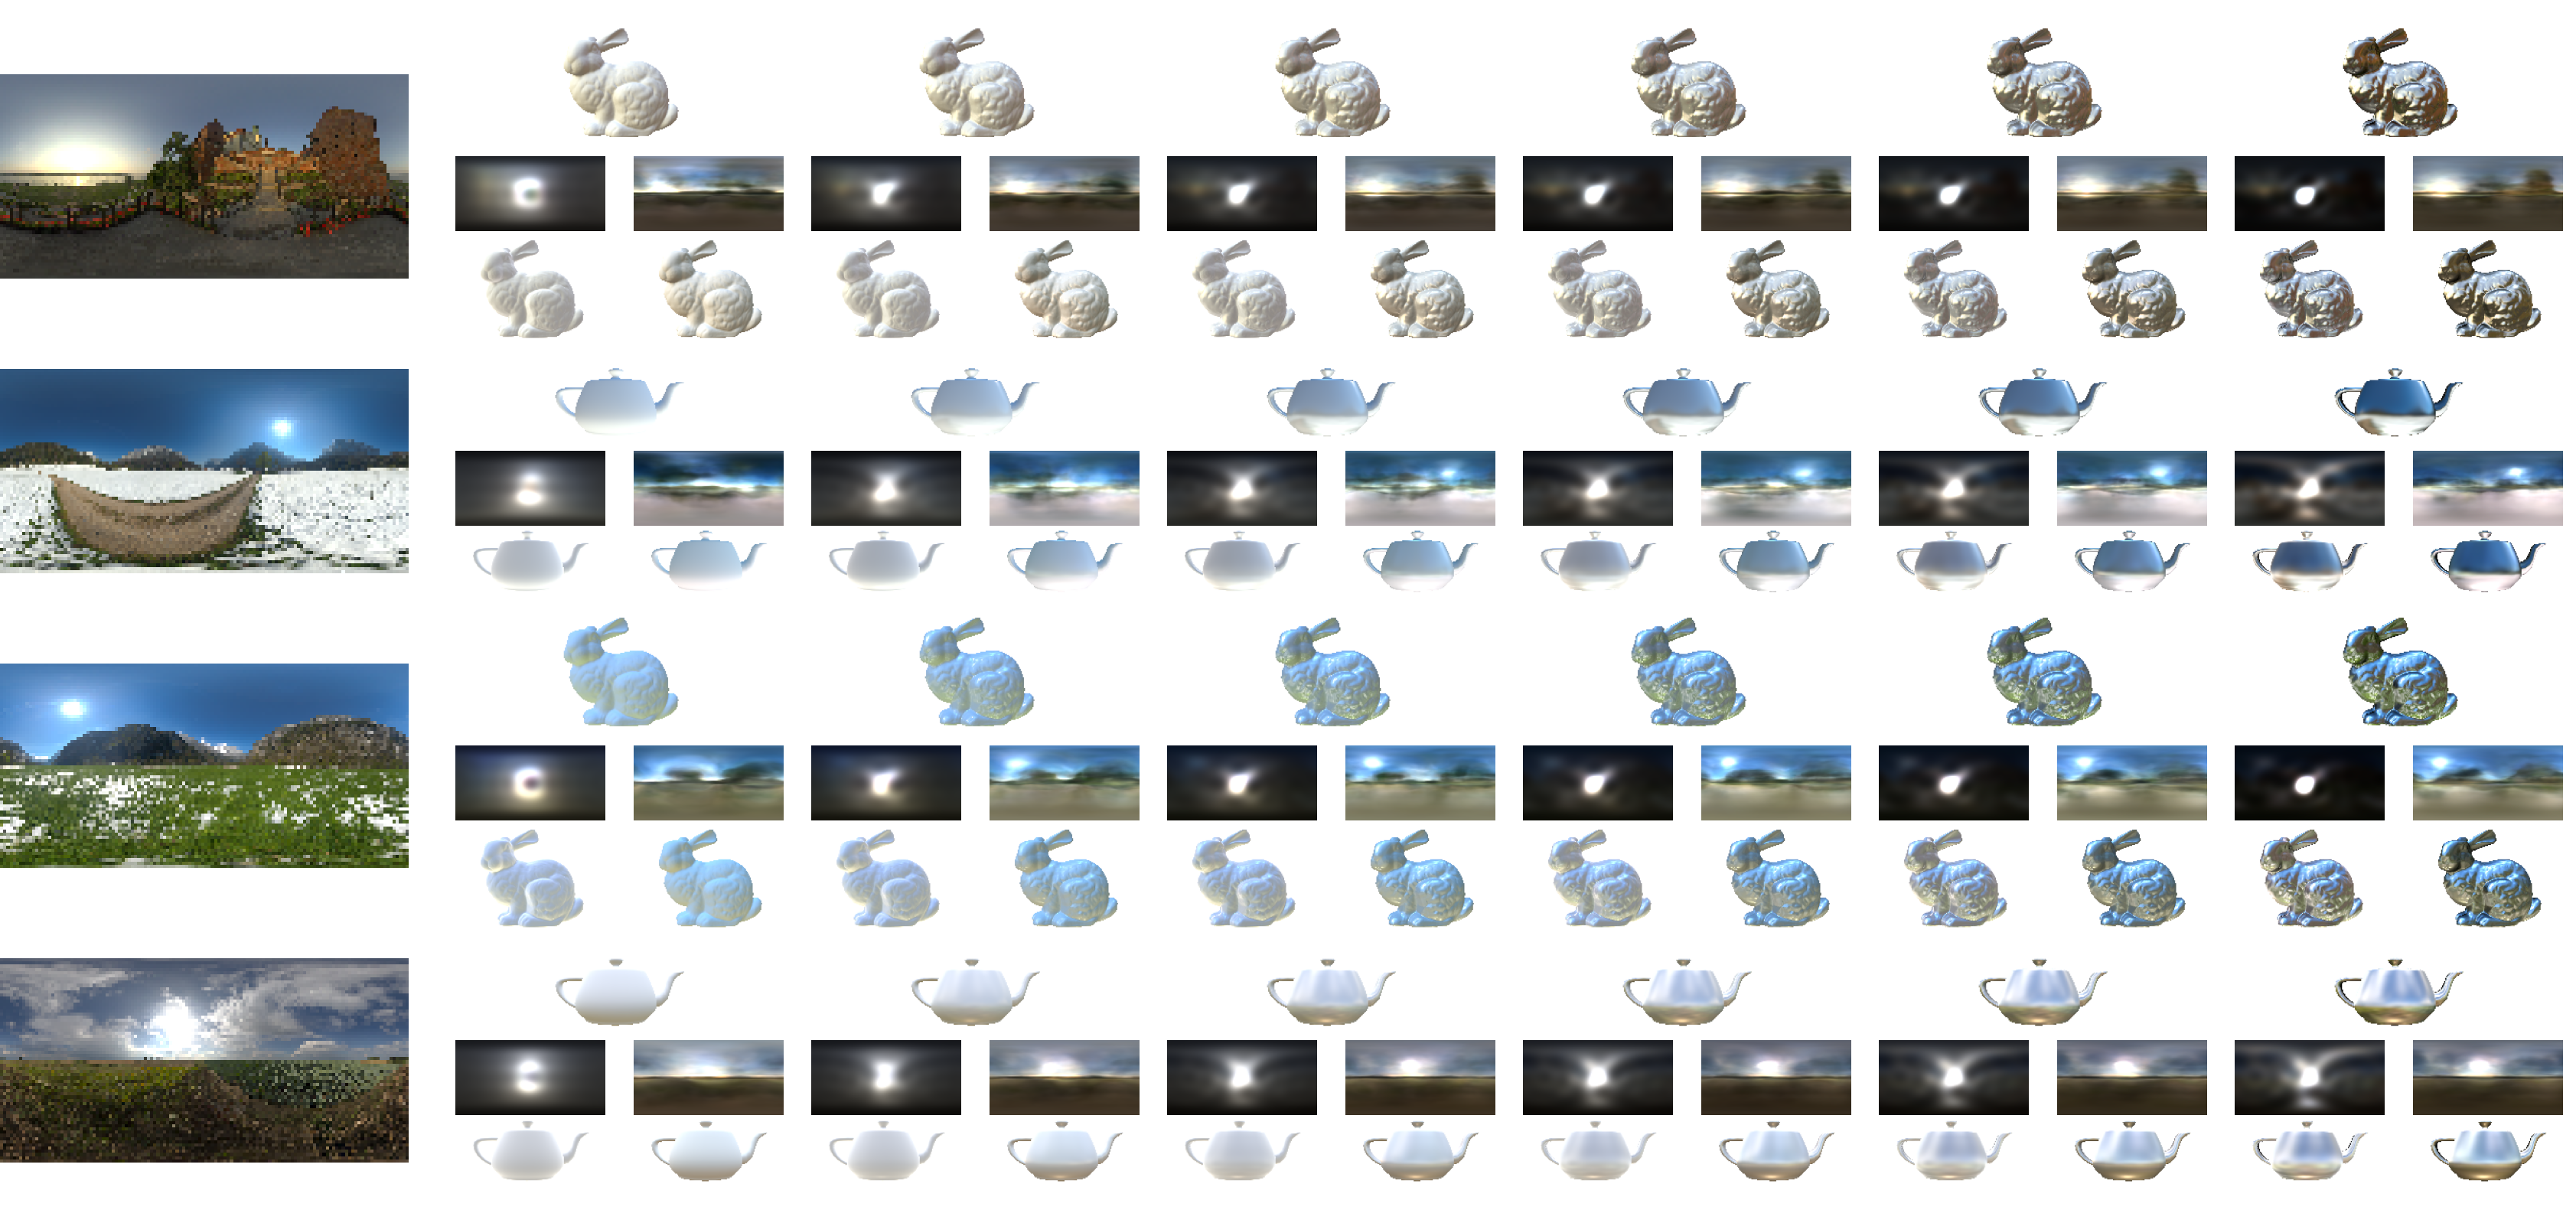

In [193]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

plt.rc('font', family='serif')

# Set the figure size in inches. One inch will correspond to `dpi` pixels.
dpi = 1  # This dpi value is just an example
fig_width = 4000 / dpi
fig_height = 2000 / dpi

fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
ax.set_facecolor('white')  # Set background to white
ax.set_axis_off()  # Turn off the axis

base_image_positions ={
    'gt_envmap': {'x': 0.0, 'y': 2000.0, 'zoom': 300.0},
    'gt_rgb': {'x': 0.0, 'y': 2000.0, 'zoom': 100.0},
    'sh_pred_envmap': {'x': 0.0, 'y': 2000.0, 'zoom': 110.0},
    'reni_pred_envmap': {'x': 0.0, 'y': 2000.0, 'zoom': 110.0},
    'sh_pred_rgb': {'x': 0.0, 'y': 2000.0, 'zoom': 90.0},
    'reni_pred_rgb': {'x': 0.0, 'y': 2000.0, 'zoom': 90.0},
}

# GT Envmaps
for i in range(4):
    # Example image retrieval; replace with your actual method of getting images
    img = output_images['9th_order'][f'{i}_0.000000']['gt_envmap'].cpu().numpy()  # Use dictionary here

    img_h, img_w, _ = img.shape

    # Compute relative positions based on figure size
    x_pos = base_image_positions['gt_envmap']['x']
    y_pos = base_image_positions['gt_envmap']['y'] - 300 - i * 500

    # Create the OffsetImage with the zoom level
    imagebox = OffsetImage(img, zoom=base_image_positions['gt_envmap']['zoom'])

    # Position is given in terms of Axes fraction
    ab = AnnotationBbox(imagebox, (x_pos / fig_width, y_pos / fig_height), frameon=False, pad=0)

    ax.add_artist(ab)
    
    block_distance_x = 600

# GT Teapots 
for i in range(4):
    for idx, specular in enumerate(['0.000000', '0.200000', '0.400000', '0.600000', '0.800000', '1.000000']):
        if i not in [0, 2]:
            img = output_images['9th_order'][f'{i}_{specular}']['gt_rgb'].cpu().numpy()
            img_h, img_w, _ = img.shape
            x_pos = base_image_positions['gt_rgb']['x'] + 700 + idx * block_distance_x
            y_pos = base_image_positions['gt_rgb']['y'] - 180 - i * 500
            imagebox = OffsetImage(img, zoom=base_image_positions['gt_rgb']['zoom'])
            ab = AnnotationBbox(imagebox, (x_pos / fig_width, y_pos / fig_height), frameon=False, pad=0)
            ax.add_artist(ab)

# Predictied Teapots
for i in range(4):
    for idx, specular in enumerate(['0.000000', '0.200000', '0.400000', '0.600000', '0.800000', '1.000000']):
        if i not in [0, 2]:
            img = output_images['9th_order'][f'{i}_{specular}']['predicted_rgb'].cpu().numpy()
            img_h, img_w, _ = img.shape
            x_pos = base_image_positions['gt_rgb']['x'] + 550 + idx * block_distance_x
            y_pos = base_image_positions['gt_rgb']['y'] - 450 - i * 500
            imagebox = OffsetImage(img, zoom=base_image_positions['sh_pred_rgb']['zoom'])
            ab = AnnotationBbox(imagebox, (x_pos / fig_width, y_pos / fig_height), frameon=False, pad=0)
            ax.add_artist(ab)
            img = output_images['latent_dim_100'][f'{i}_{specular}']['predicted_rgb'].cpu().numpy()
            img_h, img_w, _ = img.shape
            x_pos = base_image_positions['gt_rgb']['x'] + 850 + idx * block_distance_x
            y_pos = base_image_positions['gt_rgb']['y'] - 450 - i * 500
            imagebox = OffsetImage(img, zoom=base_image_positions['sh_pred_rgb']['zoom'])
            ab = AnnotationBbox(imagebox, (x_pos / fig_width, y_pos / fig_height), frameon=False, pad=0)
            ax.add_artist(ab)


for i in range(4):
    for idx, specular in enumerate(['0.000000', '0.200000', '0.400000', '0.600000', '0.800000', '1.000000']):
        if i in [0, 2]:
            img = output_images['9th_order'][f'{i}_{specular}']['gt_rgb'].cpu().numpy()
            img_h, img_w, _ = img.shape
            x_pos = base_image_positions['gt_rgb']['x'] + 700 + idx * block_distance_x
            y_pos = base_image_positions['gt_rgb']['y'] - 150 - i * 500
            imagebox = OffsetImage(img, zoom=base_image_positions['gt_rgb']['zoom'])
            ab = AnnotationBbox(imagebox, (x_pos / fig_width, y_pos / fig_height), frameon=False, pad=0)
            ax.add_artist(ab)

        img = output_images['9th_order'][f'{i}_{specular}']['pred_envmap'].cpu().numpy()
        img_h, img_w, _ = img.shape
        x_pos = base_image_positions['gt_rgb']['x'] + 550 + idx * block_distance_x
        y_pos = base_image_positions['gt_rgb']['y'] - 330 - i * 500
        imagebox = OffsetImage(img, zoom=base_image_positions['sh_pred_envmap']['zoom'])
        ab = AnnotationBbox(imagebox, (x_pos / fig_width, y_pos / fig_height), frameon=False, pad=0)
        ax.add_artist(ab)

        img = output_images['latent_dim_100'][f'{i}_{specular}']['pred_envmap'].cpu().numpy()
        img_h, img_w, _ = img.shape
        x_pos = base_image_positions['gt_rgb']['x'] + 850 + idx * block_distance_x
        y_pos = base_image_positions['gt_rgb']['y'] - 330 - i * 500
        imagebox = OffsetImage(img, zoom=base_image_positions['sh_pred_envmap']['zoom'])
        ab = AnnotationBbox(imagebox, (x_pos / fig_width, y_pos / fig_height), frameon=False, pad=0)
        ax.add_artist(ab)
    
        if i in [0, 2]:
            img = output_images['9th_order'][f'{i}_{specular}']['predicted_rgb'].cpu().numpy()
            img_h, img_w, _ = img.shape
            x_pos = base_image_positions['gt_rgb']['x'] + 550 + idx * block_distance_x
            y_pos = base_image_positions['gt_rgb']['y'] - 500 - i * 500
            imagebox = OffsetImage(img, zoom=base_image_positions['sh_pred_rgb']['zoom'])
            ab = AnnotationBbox(imagebox, (x_pos / fig_width, y_pos / fig_height), frameon=False, pad=0)
            ax.add_artist(ab)
            img = output_images['latent_dim_100'][f'{i}_{specular}']['predicted_rgb'].cpu().numpy()
            img_h, img_w, _ = img.shape
            x_pos = base_image_positions['gt_rgb']['x'] + 850 + idx * block_distance_x
            y_pos = base_image_positions['gt_rgb']['y'] - 500 - i * 500
            imagebox = OffsetImage(img, zoom=base_image_positions['sh_pred_rgb']['zoom'])
            ab = AnnotationBbox(imagebox, (x_pos / fig_width, y_pos / fig_height), frameon=False, pad=0)
            ax.add_artist(ab)

# save as png and pdf at '/workspace/reni_neus/ns_reni/publication/figures/inverse_rendering
plt.savefig('/workspace/reni_neus/ns_reni/publication/figures/inverse_rendering.png', dpi=1, bbox_inches='tight', pad_inches=0)
plt.savefig('/workspace/reni_neus/ns_reni/publication/figures/inverse_rendering.pdf', dpi=1, bbox_inches='tight', pad_inches=0)